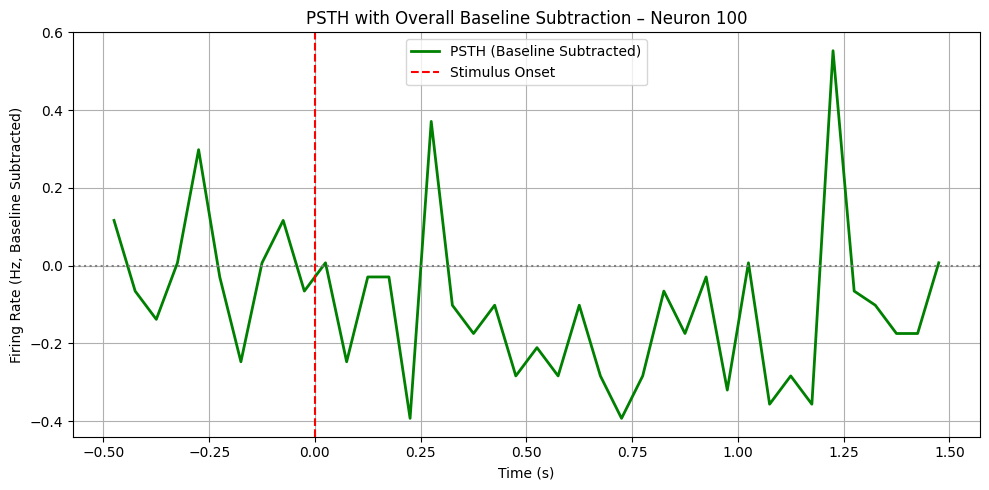

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

# Load data
df = pd.read_csv("spikes_full.csv")

# Select one neuron
neuron_id = 100
df_neuron = df[df["Neuron ID"] == neuron_id].copy()
df_neuron = df_neuron[df_neuron["Trial-Aligned Spikes (μs)"].notnull()]

# Parse spike times (μs → seconds)
df_neuron["Spike Times (s)"] = df_neuron["Trial-Aligned Spikes (μs)"].apply(
    lambda x: np.array(ast.literal_eval(x)) / 1e6
)

# Define bins: from -0.5s to 1.5s in 50ms bins
window = [-0.5, 1.5]
bin_size = 0.05
time_bins = np.arange(window[0], window[1] + bin_size, bin_size)
bin_centers = (time_bins[:-1] + time_bins[1:]) / 2

# Compute firing rate matrix (trials × time bins)
psth_matrix = []
for spikes in df_neuron["Spike Times (s)"]:
    counts, _ = np.histogram(spikes, bins=time_bins)
    fr = counts / bin_size  # Hz
    psth_matrix.append(fr)
psth_matrix = np.array(psth_matrix)

# Step 1: Compute overall baseline firing rate (−0.5 to 0s across ALL trials)
baseline_bins = bin_centers < 0
overall_baseline = psth_matrix[:, baseline_bins].mean()

# Step 2: Subtract that value from all bins in all trials
psth_baselined = psth_matrix - overall_baseline

# Step 3: Average across trials
mean_psth = psth_baselined.mean(axis=0)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(bin_centers, mean_psth, lw=2, color='green', label='PSTH (Baseline Subtracted)')
plt.axhline(0, color='gray', linestyle=':')
plt.axvline(0, color='red', linestyle='--', label='Stimulus Onset')
plt.xlabel("Time (s)")
plt.ylabel("Firing Rate (Hz, Baseline Subtracted)")
plt.title(f"PSTH with Overall Baseline Subtraction – Neuron {neuron_id}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


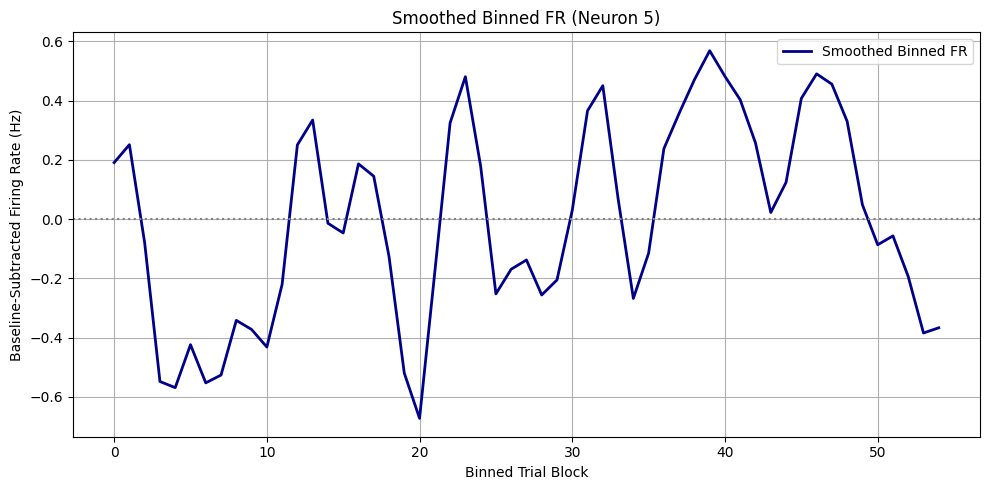

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from scipy.ndimage import gaussian_filter1d

# Load the CSV
df = pd.read_csv("spikes_full.csv")

# Select neuron of interest
neuron_id = 5
df_neuron = df[df["Neuron ID"] == neuron_id].copy()
df_neuron = df_neuron[df_neuron["Trial-Aligned Spikes (μs)"].notnull()]

# Parse spike times to seconds
df_neuron["Spike Times (s)"] = df_neuron["Trial-Aligned Spikes (μs)"].apply(
    lambda x: np.array(ast.literal_eval(x)) / 1e6
)

# Step 1: compute baseline-subtracted FR per trial
corrected_frs = []
for spikes in df_neuron["Spike Times (s)"]:
    baseline_spikes = np.sum((spikes >= -0.5) & (spikes < 0))
    full_spikes = np.sum((spikes >= -0.5) & (spikes < 1.5))

    baseline_fr = baseline_spikes / 0.5  # Hz
    full_fr = full_spikes / 2.0          # Hz

    corrected_frs.append(full_fr - baseline_fr)

corrected_frs = np.array(corrected_frs)

# Step 2: bin across trials (e.g. every 10 trials)
bin_width = 10
num_bins = len(corrected_frs) // bin_width
binned_frs = np.array([corrected_frs[i * bin_width:(i + 1) * bin_width].mean()
                       for i in range(num_bins)])

# Step 3: smooth with Gaussian
smoothed_frs = gaussian_filter1d(binned_frs, sigma=1)

# Step 4: plot
plt.figure(figsize=(10, 5))
plt.plot(smoothed_frs, lw=2, color='darkblue', label='Smoothed Binned FR')
plt.axhline(0, color='gray', linestyle=':')
plt.xlabel("Binned Trial Block")
plt.ylabel("Baseline-Subtracted Firing Rate (Hz)")
plt.title(f"Smoothed Binned FR (Neuron {neuron_id})")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()



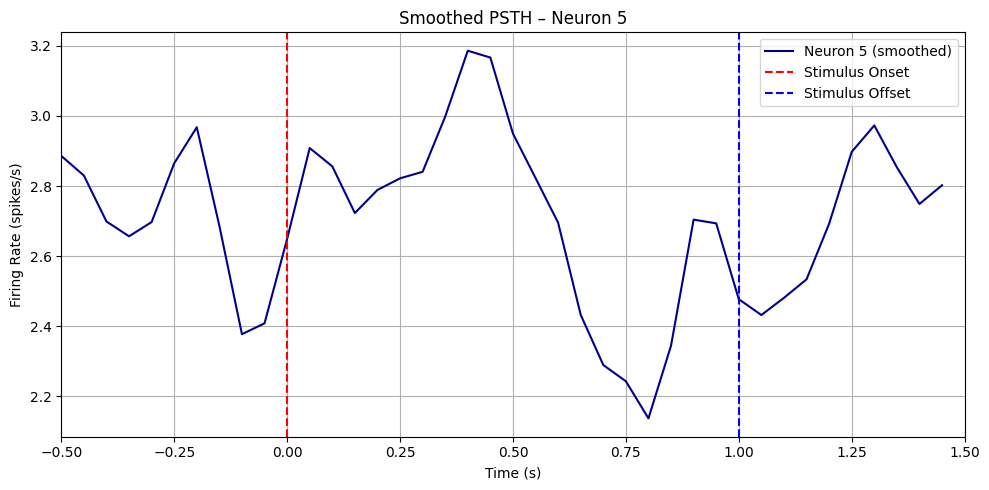

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast
from scipy.ndimage import gaussian_filter1d

# Load the CSV
df = pd.read_csv("spikes_full.csv")

# Select neuron of interest
neuron_id = 5
df_neuron = df[df["Neuron ID"] == neuron_id].copy()

# Drop rows with missing spike times
df_neuron = df_neuron[df_neuron["Trial-Aligned Spikes (μs)"].notnull()]

# Parse spike times from string to array in seconds
df_neuron["Spike Times (s)"] = df_neuron["Trial-Aligned Spikes (μs)"].apply(
    lambda x: np.array(ast.literal_eval(x)) / 1e6
)

# Parameters
window = [-0.5, 1.5]         # Time window in seconds
bin_size = 0.05              # Bin size (50 ms)
time_bins = np.arange(window[0], window[1] + bin_size, bin_size)
sigma = 1                    # Gaussian smoothing (in bins)

# Compute PSTH for each trial
def compute_psth(spike_times_list, bins):
    psth_list = []
    for spike_times in spike_times_list:
        psth, _ = np.histogram(spike_times, bins=bins)
        psth = psth / bin_size  # Convert to firing rate (spikes/sec)
        psth_list.append(psth)
    return np.array(psth_list)

# Get PSTH matrix: trials × bins
spike_times_all = df_neuron["Spike Times (s)"].tolist()
psth_matrix = compute_psth(spike_times_all, time_bins)

# Average across trials to get mean firing rate per time bin
mean_psth = np.mean(psth_matrix, axis=0)

# Apply Gaussian smoothing
smoothed_psth = gaussian_filter1d(mean_psth, sigma=sigma)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(time_bins[:-1], smoothed_psth, color='darkblue', label=f"Neuron {neuron_id} (smoothed)")
plt.axvline(0, color='red', linestyle='--', label="Stimulus Onset")
plt.axvline(1, color='blue', linestyle='--', label="Stimulus Offset")
plt.xlabel("Time (s)")
plt.ylabel("Firing Rate (spikes/s)")
plt.title(f"Smoothed PSTH – Neuron {neuron_id}")
plt.grid(True)
plt.legend()
plt.xlim(window)
plt.tight_layout()
plt.show()

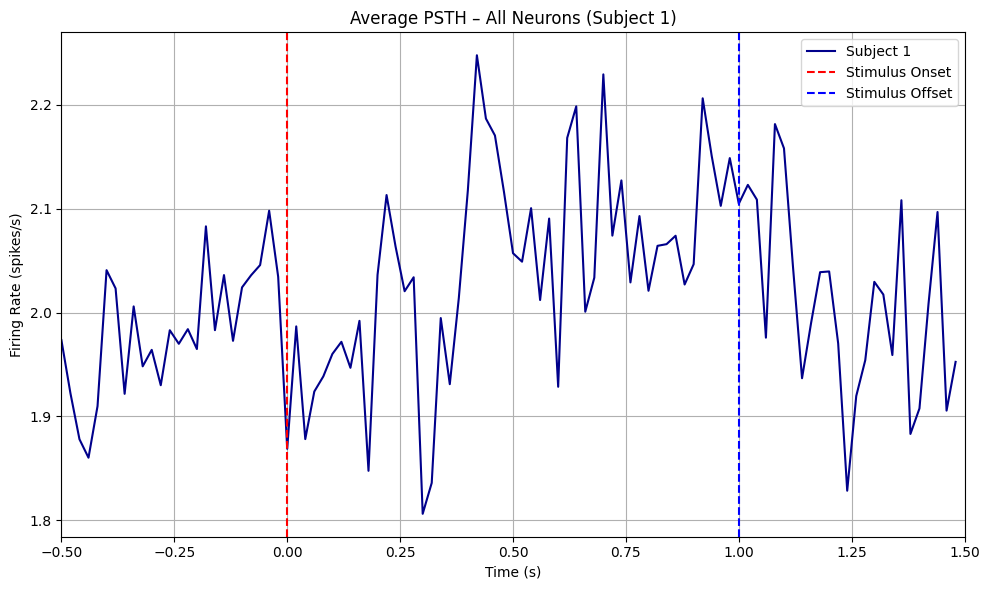

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast

# Load data
df = pd.read_csv("spikes_full.csv")

# Subject to analyze
subject_id = 1  # this is the numeric Subject ID from your file
df_subject = df[df["Subject ID"] == subject_id].copy()

# Drop trials without spike data
df_subject = df_subject[df_subject["Trial-Aligned Spikes (μs)"].notnull()]

# Parse spike times (convert strings to np arrays in seconds)
def parse_spikes(x):
    try:
        spikes = np.array(ast.literal_eval(x)) / 1e6  # μs to sec
        return spikes if len(spikes) > 0 else np.nan
    except:
        return np.nan

df_subject["Spike Times (s)"] = df_subject["Trial-Aligned Spikes (μs)"].apply(parse_spikes)
df_subject = df_subject.dropna(subset=["Spike Times (s)"])

# Time window and binning
window = [-0.5, 1.5]  # seconds
bin_size = 0.02
time_bins = np.arange(window[0], window[1] + bin_size, bin_size)

def compute_psth(spike_times_list, bins):
    psth_list = []
    for spikes in spike_times_list:
        psth, _ = np.histogram(spikes, bins=bins)
        psth = psth / bin_size
        psth_list.append(psth)
    return np.array(psth_list)

# Go neuron by neuron
mean_psths = []
for neuron_id in df_subject["Neuron ID"].unique():
    df_neuron = df_subject[df_subject["Neuron ID"] == neuron_id]
    spike_times_list = df_neuron["Spike Times (s)"].tolist()

    if len(spike_times_list) == 0:
        continue

    psth_matrix = compute_psth(spike_times_list, time_bins)
    if psth_matrix.shape[0] == 0:
        continue  # all empty

    mean_psth = np.mean(psth_matrix, axis=0)
    mean_psths.append(mean_psth)

# Plot
if len(mean_psths) == 0:
    print(f"⚠️ No neurons with spikes found for Subject {subject_id}. Cannot compute PSTH.")
else:
    mean_psths = np.array(mean_psths)
    psth_across_neurons = np.mean(mean_psths, axis=0)

    plt.figure(figsize=(10, 6))
    plt.plot(time_bins[:-1], psth_across_neurons, color='darkblue', label=f"Subject {subject_id}")
    plt.axvline(0, color='red', linestyle='--', label="Stimulus Onset")
    plt.axvline(1, color='blue', linestyle='--', label="Stimulus Offset")
    plt.xlabel("Time (s)")
    plt.ylabel("Firing Rate (spikes/s)")
    plt.title(f"Average PSTH – All Neurons (Subject {subject_id})")
    plt.legend()
    plt.grid(True)
    plt.xlim(window)
    plt.tight_layout()
    plt.show()

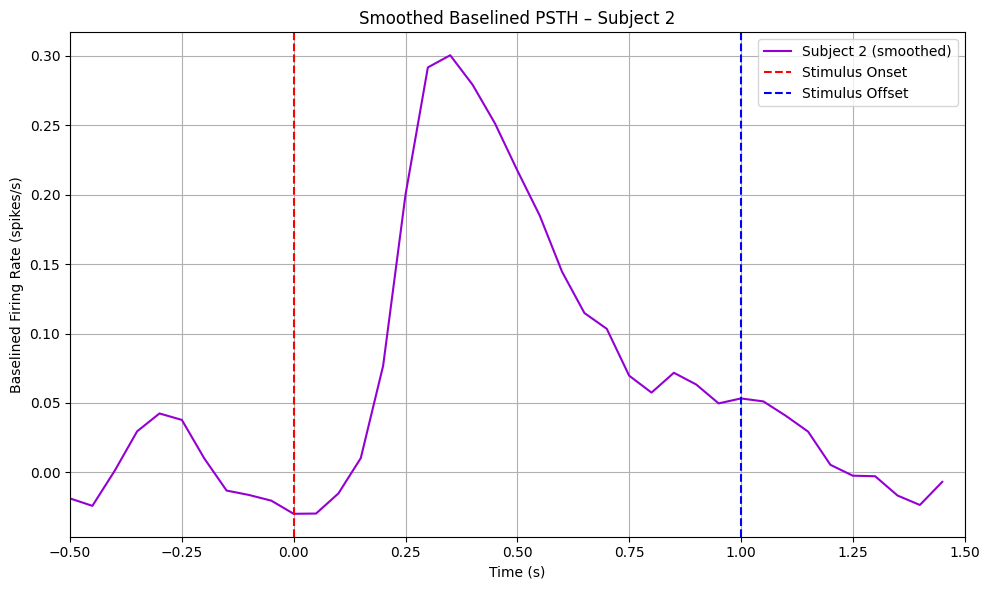

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast
from scipy.ndimage import gaussian_filter1d

# Load data
df = pd.read_csv("spikes_full.csv")

# Params
subject_id = 2
window = [-0.5, 1.5]
bin_size = 0.05
time_bins = np.arange(window[0], window[1] + bin_size, bin_size)
sigma = 1  # smoothing width in bins (~10 ms for 5 ms bins)

# Baseline window
baseline_window = [-0.5, 0.0]
baseline_mask = (time_bins[:-1] >= baseline_window[0]) & (time_bins[:-1] < baseline_window[1])

# Parse spikes
def parse_spikes(x):
    try:
        spikes = np.array(ast.literal_eval(x)) / 1e6
        return spikes if len(spikes) > 0 else np.nan
    except:
        return np.nan

df["Spike Times (s)"] = df["Trial-Aligned Spikes (μs)"].apply(parse_spikes)
df = df.dropna(subset=["Spike Times (s)", "Recognition"])
df_subject = df[df["Subject ID"] == subject_id]

# Compute PSTH
psth_list = []
for neuron_id in df_subject["Neuron ID"].unique():
    df_neuron = df_subject[df_subject["Neuron ID"] == neuron_id]
    for _, row in df_neuron.iterrows():
        spikes = row["Spike Times (s)"]
        psth, _ = np.histogram(spikes, bins=time_bins)
        psth = psth / bin_size

        baseline = np.mean(psth[baseline_mask])
        baselined_psth = psth - baseline

        psth_list.append(baselined_psth)

# Average and smooth
psth_array = np.array(psth_list)
mean_baselined = np.mean(psth_array, axis=0)
smoothed_psth = gaussian_filter1d(mean_baselined, sigma=sigma)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(time_bins[:-1], smoothed_psth, color='darkviolet', label=f"Subject {subject_id} (smoothed)")
plt.axvline(0, color='red', linestyle='--', label="Stimulus Onset")
plt.axvline(1, color='blue', linestyle='--', label="Stimulus Offset")
plt.xlabel("Time (s)")
plt.ylabel("Baselined Firing Rate (spikes/s)")
plt.title(f"Smoothed Baselined PSTH – Subject {subject_id}")
plt.grid(True)
plt.legend()
plt.xlim(window)
plt.tight_layout()
plt.show()


✅ Total neuron-trials: 28792
❌ Trials removed (mean FR ≤ 0): 11525
✅ Trials kept: 17267
🧠 Neurons kept: 95
🗑️ Neurons removed: 0


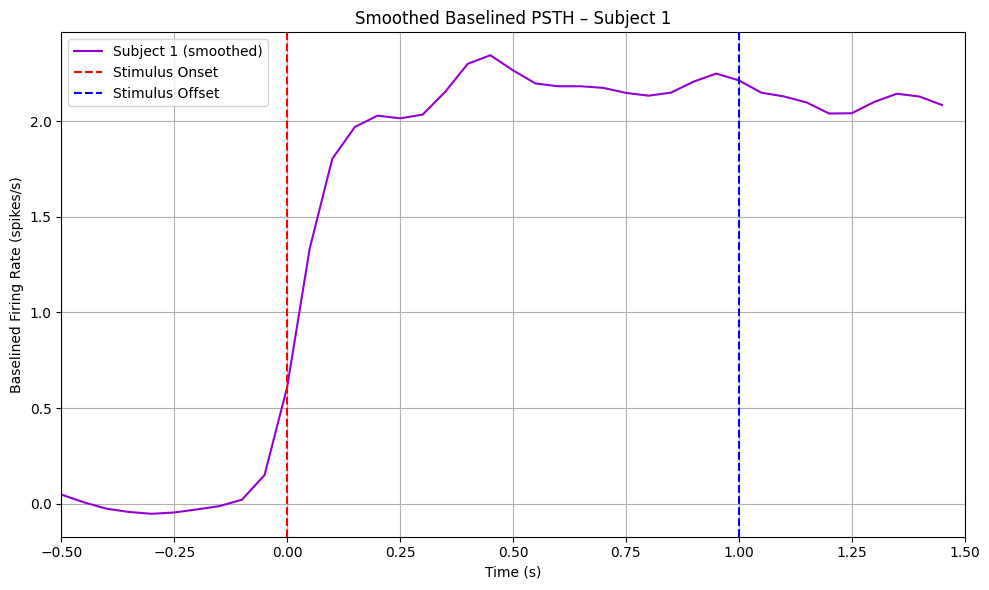

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast
from scipy.ndimage import gaussian_filter1d

# Load data
df = pd.read_csv("spikes_full.csv")

# Parameters
subject_id = 1
window = [-0.5, 1.5]
bin_size = 0.05
time_bins = np.arange(window[0], window[1] + bin_size, bin_size)
sigma = 1  # smoothing
baseline_mask = (time_bins[:-1] >= -0.5) & (time_bins[:-1] < 0)

# Parse spike times
def parse_spikes(x):
    try:
        spikes = np.array(ast.literal_eval(x)) / 1e6
        return spikes if len(spikes) > 0 else np.nan
    except:
        return np.nan

df["Spike Times (s)"] = df["Trial-Aligned Spikes (μs)"].apply(parse_spikes)
df = df.dropna(subset=["Spike Times (s)", "Recognition"])
df_subject = df[df["Subject ID"] == subject_id]

# Initialize
psth_list = []
used_neurons = set()
total_trials = 0
removed_trials = 0
removed_neurons = set()

# Go neuron by neuron
for neuron_id in df_subject["Neuron ID"].unique():
    df_neuron = df_subject[df_subject["Neuron ID"] == neuron_id]
    neuron_psths = []
    kept_any = False

    for _, row in df_neuron.iterrows():
        total_trials += 1

        spikes = row["Spike Times (s)"]
        psth, _ = np.histogram(spikes, bins=time_bins)
        psth = psth / bin_size
        baseline = np.mean(psth[baseline_mask])
        baselined_psth = psth - baseline

        if np.mean(baselined_psth) > 0:
            kept_any = True
            neuron_psths.append(baselined_psth)
        else:
            removed_trials += 1

    if kept_any:
        used_neurons.add(neuron_id)
        psth_list.extend(neuron_psths)
    else:
        removed_neurons.add(neuron_id)

# Print summary
print(f"✅ Total neuron-trials: {total_trials}")
print(f"❌ Trials removed (mean FR ≤ 0): {removed_trials}")
print(f"✅ Trials kept: {total_trials - removed_trials}")
print(f"🧠 Neurons kept: {len(used_neurons)}")
print(f"🗑️ Neurons removed: {len(removed_neurons)}")

# Plot PSTH
if len(psth_list) == 0:
    print("⚠️ No neurons with valid trials found.")
else:
    psth_array = np.array(psth_list)
    mean_baselined = np.mean(psth_array, axis=0)
    smoothed_psth = gaussian_filter1d(mean_baselined, sigma=sigma)

    plt.figure(figsize=(10, 6))
    plt.plot(time_bins[:-1], smoothed_psth, color='darkviolet', label=f"Subject {subject_id} (smoothed)")
    plt.axvline(0, color='red', linestyle='--', label="Stimulus Onset")
    plt.axvline(1, color='blue', linestyle='--', label="Stimulus Offset")
    plt.xlabel("Time (s)")
    plt.ylabel("Baselined Firing Rate (spikes/s)")
    plt.title(f"Smoothed Baselined PSTH – Subject {subject_id}")
    plt.grid(True)
    plt.legend()
    plt.xlim(window)
    plt.tight_layout()
    plt.show()


🧠 Neurons kept: 82
🗑️ Neurons removed (overall mean FR ≤ 0): 48
📊 Total trials processed: 52434
✅ Trials used in PSTH: 33576


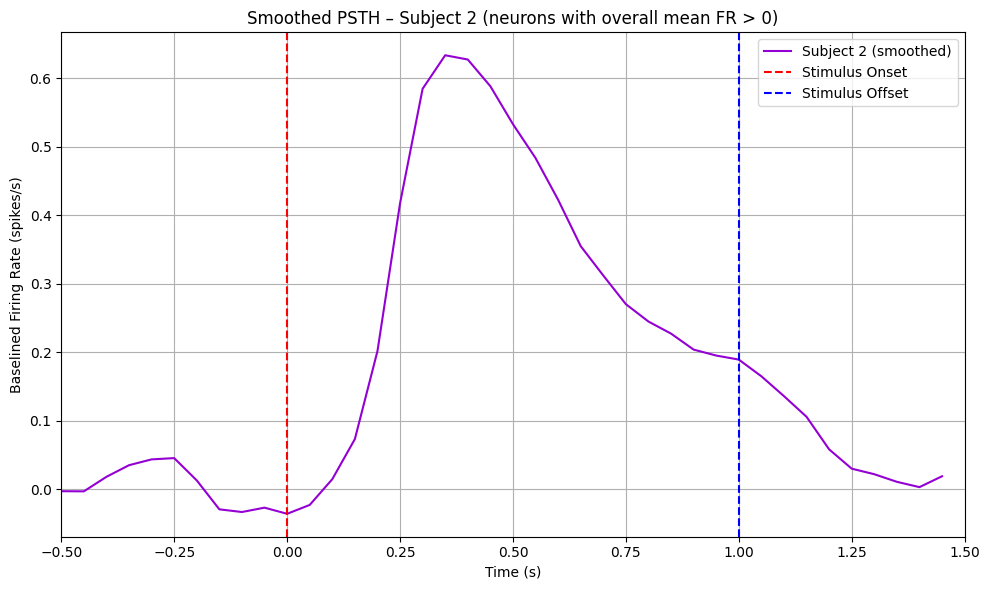

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast
from scipy.ndimage import gaussian_filter1d

# Load data
df = pd.read_csv("spikes_full.csv")

# Parameters
subject_id = 2
window = [-0.5, 1.5]
bin_size = 0.05
time_bins = np.arange(window[0], window[1] + bin_size, bin_size)
sigma = 1
baseline_mask = (time_bins[:-1] >= -0.5) & (time_bins[:-1] < 0)

# Parse spike times
def parse_spikes(x):
    try:
        spikes = np.array(ast.literal_eval(x)) / 1e6
        return spikes if len(spikes) > 0 else np.nan
    except:
        return np.nan

df["Spike Times (s)"] = df["Trial-Aligned Spikes (μs)"].apply(parse_spikes)
df = df.dropna(subset=["Spike Times (s)", "Recognition"])
df_subject = df[df["Subject ID"] == subject_id]

# Initialize
psth_list = []
kept_neurons = []
removed_neurons = []
total_trials = 0

# Go neuron by neuron
for neuron_id in df_subject["Neuron ID"].unique():
    df_neuron = df_subject[df_subject["Neuron ID"] == neuron_id]
    all_psths = []

    for _, row in df_neuron.iterrows():
        total_trials += 1

        spikes = row["Spike Times (s)"]
        psth, _ = np.histogram(spikes, bins=time_bins)
        psth = psth / bin_size
        baseline = np.mean(psth[baseline_mask])
        baselined_psth = psth - baseline
        all_psths.append(baselined_psth)

    if len(all_psths) == 0:
        removed_neurons.append(neuron_id)
        continue

    all_psths = np.array(all_psths)
    mean_fr_across_trials_and_time = np.mean(all_psths)

    if mean_fr_across_trials_and_time <= 0:
        removed_neurons.append(neuron_id)
    else:
        kept_neurons.append(neuron_id)
        psth_list.extend(all_psths)

# Print summary
print(f"🧠 Neurons kept: {len(kept_neurons)}")
print(f"🗑️ Neurons removed (overall mean FR ≤ 0): {len(removed_neurons)}")
print(f"📊 Total trials processed: {total_trials}")
print(f"✅ Trials used in PSTH: {len(psth_list)}")

# Plot
if len(psth_list) == 0:
    print("⚠️ No valid neurons found.")
else:
    psth_array = np.array(psth_list)
    mean_baselined = np.mean(psth_array, axis=0)
    smoothed_psth = gaussian_filter1d(mean_baselined, sigma=sigma)

    plt.figure(figsize=(10, 6))
    plt.plot(time_bins[:-1], smoothed_psth, color='darkviolet', label=f"Subject {subject_id} (smoothed)")
    plt.axvline(0, color='red', linestyle='--', label="Stimulus Onset")
    plt.axvline(1, color='blue', linestyle='--', label="Stimulus Offset")
    plt.xlabel("Time (s)")
    plt.ylabel("Baselined Firing Rate (spikes/s)")
    plt.title(f"Smoothed PSTH – Subject {subject_id} (neurons with overall mean FR > 0)")
    plt.grid(True)
    plt.legend()
    plt.xlim(window)
    plt.tight_layout()
    plt.show()

✅ Total neuron-trials: 54025
🧠 Neurons kept: 27
🗑️ Neurons removed (mean FR < 0.15): 121
✅ Trials used in PSTH: 11473


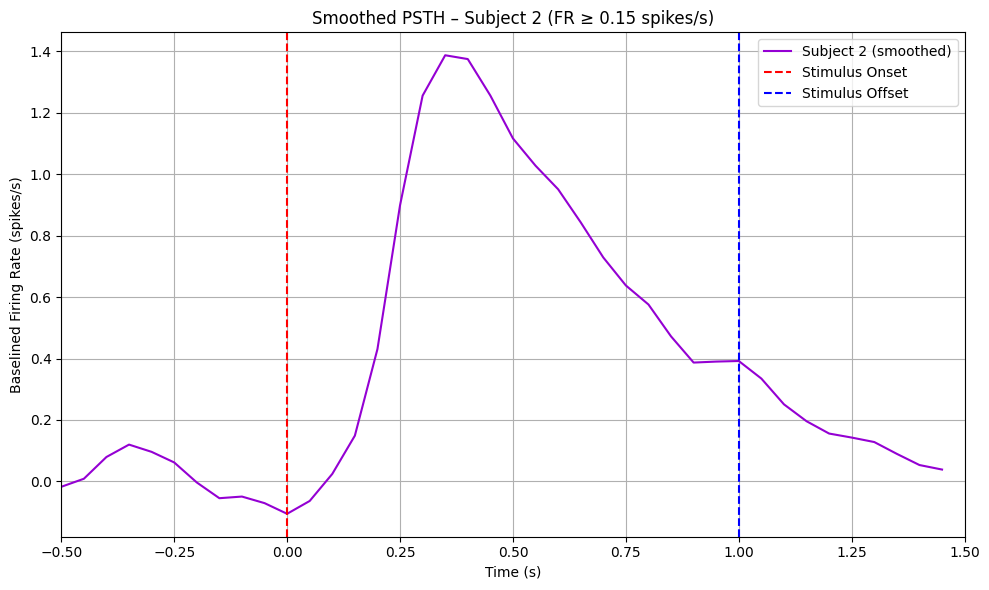

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast
from scipy.ndimage import gaussian_filter1d

# Load data
df = pd.read_csv("spikes_full.csv")

# Parameters
subject_id = 2
window = [-0.5, 1.5]
bin_size = 0.05
time_bins = np.arange(window[0], window[1] + bin_size, bin_size)
sigma = 1  # Gaussian smoothing
threshold = 0.15  # 🔥 NEW threshold
baseline_mask = (time_bins[:-1] >= -0.5) & (time_bins[:-1] < 0)

# Parse spike times
def parse_spikes(x):
    try:
        spikes = np.array(ast.literal_eval(x)) / 1e6
        return spikes if len(spikes) > 0 else np.nan
    except:
        return np.nan

df["Spike Times (s)"] = df["Trial-Aligned Spikes (μs)"].apply(parse_spikes)
df = df.dropna(subset=["Spike Times (s)", "Recognition"])
df_subject = df[df["Subject ID"] == subject_id]

# Initialize
psth_list = []
kept_neurons = []
removed_neurons = []
total_trials = 0

# Go neuron by neuron
for neuron_id in df_subject["Neuron ID"].unique():
    df_neuron = df_subject[df_subject["Neuron ID"] == neuron_id]
    all_psths = []

    for _, row in df_neuron.iterrows():
        total_trials += 1

        spikes = row["Spike Times (s)"]
        psth, _ = np.histogram(spikes, bins=time_bins)
        psth = psth / bin_size
        baseline = np.mean(psth[baseline_mask])
        baselined_psth = psth - baseline
        all_psths.append(baselined_psth)

    if len(all_psths) == 0:
        removed_neurons.append(neuron_id)
        continue

    all_psths = np.array(all_psths)
    mean_fr = np.mean(all_psths)

    if mean_fr < threshold:  # 🔥 New threshold check
        removed_neurons.append(neuron_id)
    else:
        kept_neurons.append(neuron_id)
        psth_list.extend(all_psths)

# Print summary
print(f"✅ Total neuron-trials: {total_trials}")
print(f"🧠 Neurons kept: {len(kept_neurons)}")
print(f"🗑️ Neurons removed (mean FR < {threshold}): {len(removed_neurons)}")
print(f"✅ Trials used in PSTH: {len(psth_list)}")

# Plot
if len(psth_list) == 0:
    print("⚠️ No valid neurons passed the threshold.")
else:
    psth_array = np.array(psth_list)
    mean_baselined = np.mean(psth_array, axis=0)
    smoothed_psth = gaussian_filter1d(mean_baselined, sigma=sigma)

    plt.figure(figsize=(10, 6))
    plt.plot(time_bins[:-1], smoothed_psth, color='darkviolet', label=f"Subject {subject_id} (smoothed)")
    plt.axvline(0, color='red', linestyle='--', label="Stimulus Onset")
    plt.axvline(1, color='blue', linestyle='--', label="Stimulus Offset")
    plt.xlabel("Time (s)")
    plt.ylabel("Baselined Firing Rate (spikes/s)")
    plt.title(f"Smoothed PSTH – Subject {subject_id} (FR ≥ {threshold} spikes/s)")
    plt.grid(True)
    plt.legend()
    plt.xlim(window)
    plt.tight_layout()
    plt.show()

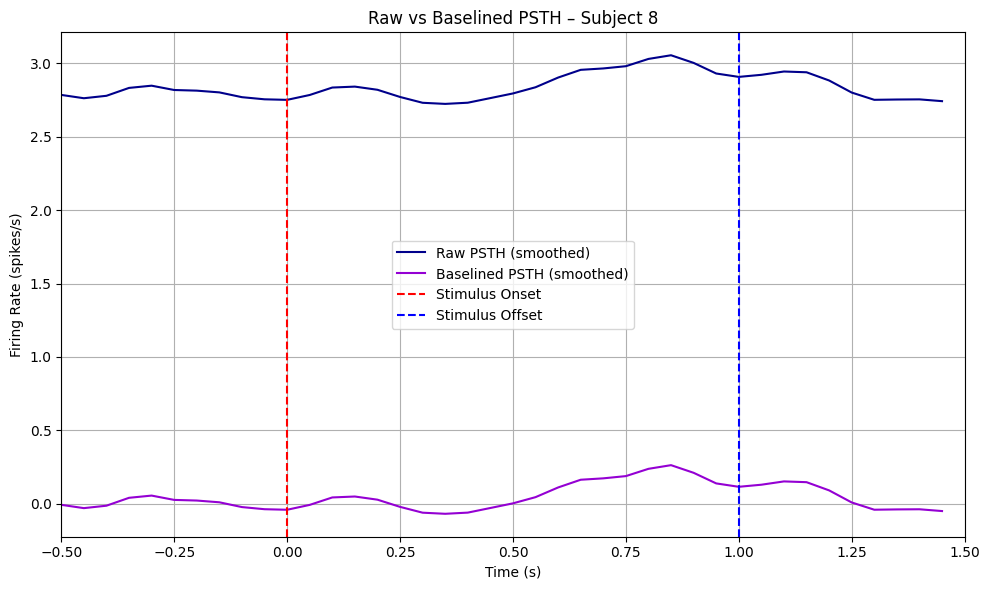

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast
from scipy.ndimage import gaussian_filter1d

# Load data
df = pd.read_csv("spikes_full.csv")

# Params
subject_id = 8
window = [-0.5, 1.5]
bin_size = 0.05
time_bins = np.arange(window[0], window[1] + bin_size, bin_size)
sigma = 1  # smoothing width (in bins)

# Baseline window
baseline_window = [-0.5, 0.0]
baseline_mask = (time_bins[:-1] >= baseline_window[0]) & (time_bins[:-1] < baseline_window[1])

# Parse spike times
def parse_spikes(x):
    try:
        spikes = np.array(ast.literal_eval(x)) / 1e6
        return spikes if len(spikes) > 0 else np.nan
    except:
        return np.nan

df["Spike Times (s)"] = df["Trial-Aligned Spikes (μs)"].apply(parse_spikes)
df = df.dropna(subset=["Spike Times (s)", "Recognition"])
df_subject = df[df["Subject ID"] == subject_id]

# Initialize lists for both raw and baselined PSTHs
raw_psths = []
baselined_psths = []

# Loop over neurons and trials
for neuron_id in df_subject["Neuron ID"].unique():
    df_neuron = df_subject[df_subject["Neuron ID"] == neuron_id]
    for _, row in df_neuron.iterrows():
        spikes = row["Spike Times (s)"]
        psth, _ = np.histogram(spikes, bins=time_bins)
        psth = psth / bin_size  # spikes/sec

        # Add raw version
        raw_psths.append(psth)

        # Baselined version
        baseline = np.mean(psth[baseline_mask])
        baselined = psth - baseline
        baselined_psths.append(baselined)

# Convert to arrays
raw_psth_array = np.array(raw_psths)
baselined_psth_array = np.array(baselined_psths)

# Compute means
mean_raw = np.mean(raw_psth_array, axis=0)
mean_baselined = np.mean(baselined_psth_array, axis=0)

# Smooth both
smooth_raw = gaussian_filter1d(mean_raw, sigma=sigma)
smooth_baselined = gaussian_filter1d(mean_baselined, sigma=sigma)

# Plot both
plt.figure(figsize=(10, 6))
plt.plot(time_bins[:-1], smooth_raw, color='darkblue', label='Raw PSTH (smoothed)')
plt.plot(time_bins[:-1], smooth_baselined, color='darkviolet', label='Baselined PSTH (smoothed)')
plt.axvline(0, color='red', linestyle='--', label='Stimulus Onset')
plt.axvline(1, color='blue', linestyle='--', label='Stimulus Offset')
plt.xlabel("Time (s)")
plt.ylabel("Firing Rate (spikes/s)")
plt.title(f"Raw vs Baselined PSTH – Subject {subject_id}")
plt.grid(True)
plt.legend()
plt.xlim(window)
plt.tight_layout()
plt.show()


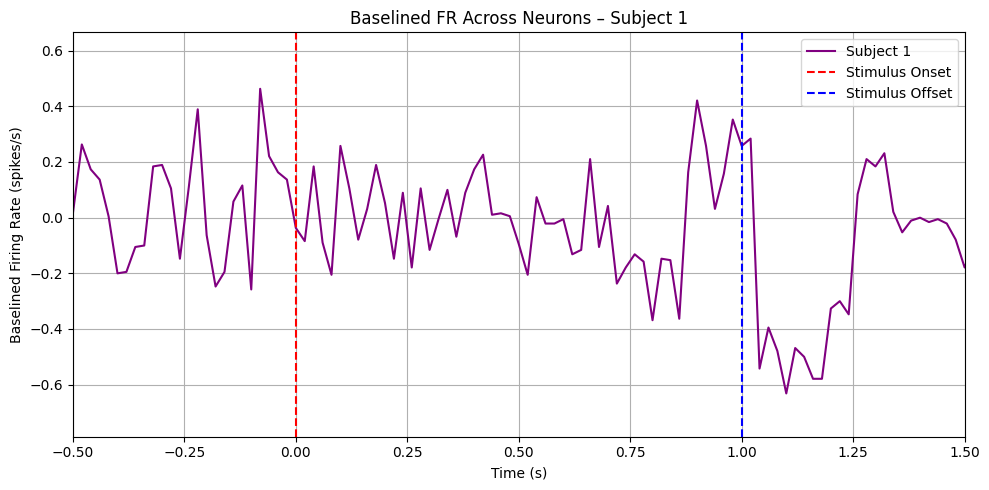

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
df = pd.read_csv("spikes_full.csv")

# Select subject
subject_id = 1
df_subject = df[df["Subject ID"] == subject_id].copy()

# Drop missing Baselined FR
df_subject = df_subject[df_subject["Baselined FR"].notnull()]

# Time setup
step_size = 0.02  # in seconds
window = [-0.5, 1.5]

# Get average Baselined FR per trial per neuron
mean_fr_matrix = []  # rows = neurons, columns = trial-indexed FRs

for neuron_id in df_subject["Neuron ID"].unique():
    df_neuron = df_subject[df_subject["Neuron ID"] == neuron_id]
    if len(df_neuron) == 0:
        continue
    fr_values = df_neuron["Baselined FR"].values
    mean_fr_matrix.append(fr_values)

# Check and plot
if len(mean_fr_matrix) == 0:
    print(f"⚠️ No Baselined FR values found for Subject {subject_id}.")
else:
    # Make it a 2D array: neurons x trials
    fr_matrix = np.stack(mean_fr_matrix, axis=0)  # shape: (neurons x trials)
    
    # Trim to shortest length to avoid shape mismatches
    min_len = min([len(x) for x in mean_fr_matrix])
    fr_matrix = np.array([x[:min_len] for x in mean_fr_matrix])

    # Average across neurons
    mean_baselined_fr = np.mean(fr_matrix, axis=0)

    # Time axis
    time_axis = np.arange(0, len(mean_baselined_fr)) * step_size + window[0]

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(time_axis, mean_baselined_fr, color='purple', label=f"Subject {subject_id}")
    plt.axvline(0, color='red', linestyle='--', label="Stimulus Onset")
    plt.axvline(1, color='blue', linestyle='--', label="Stimulus Offset")
    plt.xlabel("Time (s)")
    plt.ylabel("Baselined Firing Rate (spikes/s)")
    plt.title(f"Baselined FR Across Neurons – Subject {subject_id}")
    plt.grid(True)
    plt.legend()
    plt.xlim(window)
    plt.tight_layout()
    plt.show()

In [13]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("spikes_full.csv")
df = df[df["Subject ID"] == 1].copy()
df["Trial-Aligned Spikes (ms)"] = df["Trial-Aligned Spikes (ms)"].apply(ast.literal_eval)

# Define bins
bin_edges = np.arange(-500, 1550, 50)
bin_labels = [f"{int(start)} to {int(end)}" for start, end in zip(bin_edges[:-1], bin_edges[1:])]
bin_duration = 0.05

# Prepare structure to collect binned FRs per neuron
neuron_bins = {}

# Loop through all trials, bin spikes, accumulate per neuron
for _, row in df.iterrows():
    neuron_id = row["Neuron ID"]
    spikes = np.array(row["Trial-Aligned Spikes (ms)"])
    binned_counts, _ = np.histogram(spikes, bins=bin_edges)
    fr = binned_counts / bin_duration  # convert to Hz
    
    if neuron_id not in neuron_bins:
        neuron_bins[neuron_id] = []
    
    neuron_bins[neuron_id].append(fr)

# Compute average firing rate per bin per neuron
avg_fr_per_neuron = {}
for neuron_id, all_trials in neuron_bins.items():
    all_trials_array = np.array(all_trials)
    avg_fr = np.mean(all_trials_array, axis=0)
    avg_fr_per_neuron[neuron_id] = avg_fr

# Convert to DataFrame
avg_fr_df = pd.DataFrame.from_dict(avg_fr_per_neuron, orient="index", columns=bin_labels).reset_index()
avg_fr_df.rename(columns={"index": "Neuron ID"}, inplace=True)

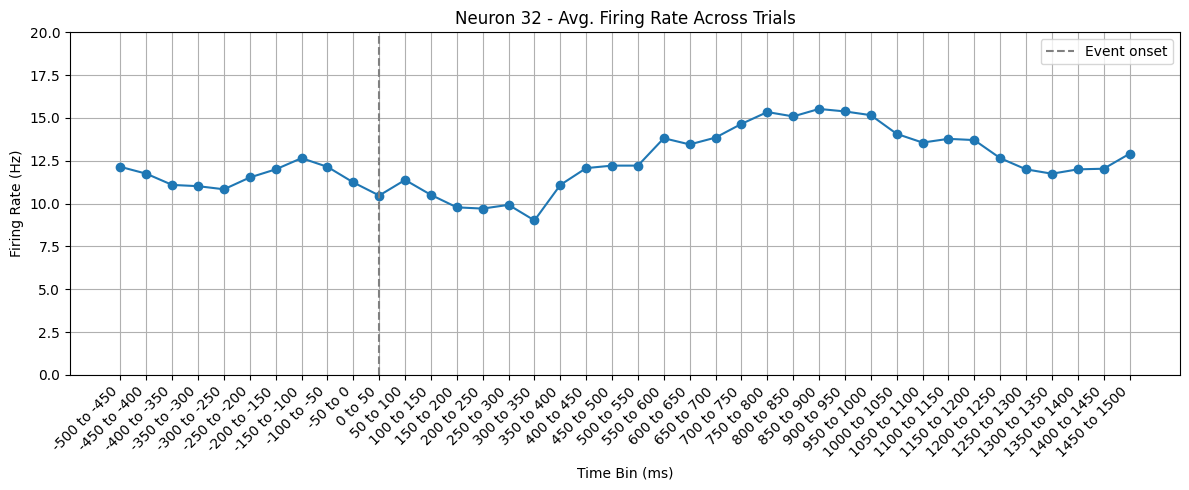

In [ ]:
# Plot for one neuron using bin labels as x-axis
neuron_id = 32
neuron_row = avg_fr_df[avg_fr_df["Neuron ID"] == neuron_id]
fr_values = neuron_row[bin_labels].values.flatten()

plt.figure(figsize=(12, 5))
plt.plot(bin_labels, fr_values, marker='o')
plt.axvline(x=bin_labels[bin_labels.index("0 to 50")], color='gray', linestyle='--', label='Event onset')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.title(f"Neuron {neuron_id} - Avg. Firing Rate Across Trials")
plt.xlabel("Time Bin (ms)")
plt.ylim(-5,20)
plt.ylabel("Firing Rate (Hz)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [36]:
# Define baseline window
baseline_bin_labels = [label for label in bin_labels if int(label.split(" to ")[0]) >= -500 and int(label.split(" to ")[1]) <= 0]
baseline_bin_indices = [bin_labels.index(label) for label in baseline_bin_labels]

# Grab trials for neuron 0
neuron_id = 32
neuron_trials = np.array(neuron_bins[neuron_id])  # shape: (n_trials, n_bins)

# Slice only baseline bins
baseline_trials = neuron_trials[:, baseline_bin_indices]

# Compute average baseline firing rate (mean across bins and trials)
avg_baseline_fr = np.mean(baseline_trials)

print(f"Neuron {neuron_id} average baseline firing rate (-500 to 0ms): {avg_baseline_fr:.2f} Hz")


Neuron 32 average baseline firing rate (-500 to 0ms): 11.64 Hz


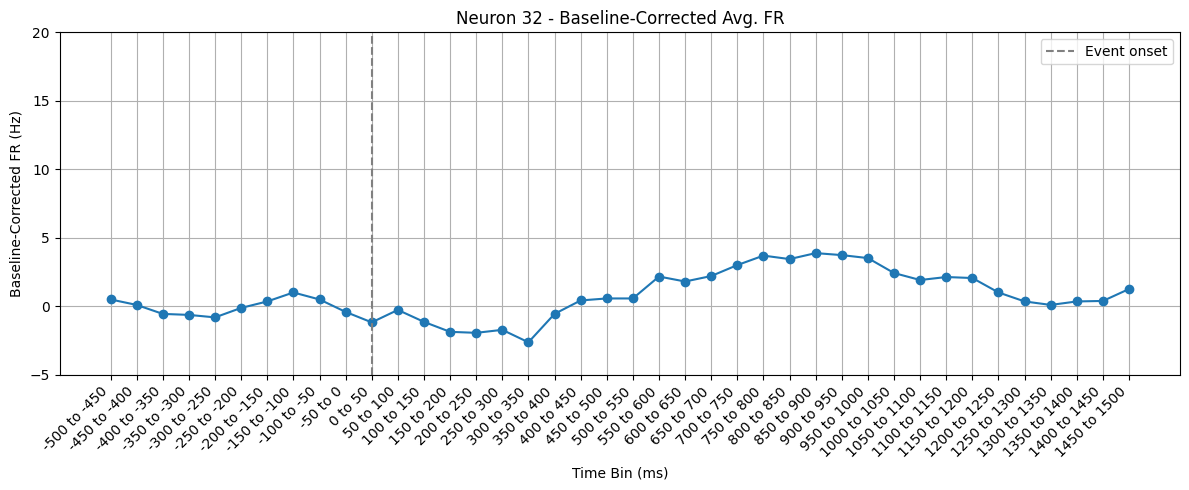

In [39]:
# Subtract baseline from averaged FR across all bins
corrected_fr_values = avg_fr_df[avg_fr_df["Neuron ID"] == neuron_id][bin_labels].values.flatten() - avg_baseline_fr

# Plot the corrected values
plt.figure(figsize=(12, 5))
plt.plot(bin_labels, corrected_fr_values, marker='o')
plt.axvline(x=bin_labels[bin_labels.index("0 to 50")], color='gray', linestyle='--', label='Event onset')
plt.xticks(rotation=45, ha='right')
plt.title(f"Neuron {neuron_id} - Baseline-Corrected Avg. FR")
plt.xlabel("Time Bin (ms)")
plt.ylim(-5,20)
plt.ylabel("Baseline-Corrected FR (Hz)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [17]:
import pandas as pd
import numpy as np
import ast

# Load and filter data
df = pd.read_csv("spikes_full.csv")
df = df[df["Subject ID"] == 1].copy()

# Convert spike strings to lists
df["Trial-Aligned Spikes (ms)"] = df["Trial-Aligned Spikes (ms)"].apply(ast.literal_eval)

# Define full window bins
bin_edges = np.arange(-500, 1550, 50)
bin_duration = 0.05  # seconds
n_bins = len(bin_edges) - 1

# Create a dict to collect firing rates for each neuron
neuron_bins = {}

# Bin spikes and compute FR per trial
for _, row in df.iterrows():
    neuron_id = row["Neuron ID"]
    spikes = np.array(row["Trial-Aligned Spikes (ms)"])
    binned_counts, _ = np.histogram(spikes, bins=bin_edges)
    fr = binned_counts / bin_duration  # Convert to Hz

    if neuron_id not in neuron_bins:
        neuron_bins[neuron_id] = []
    
    neuron_bins[neuron_id].append(fr)

# Compute overall average FR across all trials and all bins for each neuron
avg_overall_fr_per_neuron = {
    neuron_id: np.mean(np.array(trials))  # average across all bins + all trials
    for neuron_id, trials in neuron_bins.items()
}

# Convert to DataFrame
avg_overall_fr_df = pd.DataFrame.from_dict(avg_overall_fr_per_neuron, orient="index", columns=["Avg FR (-500 to 1500ms)"])
avg_overall_fr_df.index.name = "Neuron ID"
avg_overall_fr_df.reset_index(inplace=True)

print(avg_overall_fr_df)


    Neuron ID  Avg FR (-500 to 1500ms)
0           0                 0.260909
1           1                 0.045455
2           2                 5.121818
3           3                 0.065455
4           4                 1.876364
..        ...                      ...
90         90                 0.120909
91         91                 1.059091
92         92                 0.657273
93         93                 0.322727
94         94                 3.303636

[95 rows x 2 columns]


In [18]:
# Set the threshold
threshold = 0.15

# Drop neurons below the threshold
filtered_fr_df = avg_overall_fr_df[avg_overall_fr_df["Avg FR (-500 to 1500ms)"] >= threshold].copy()

# Count remaining neurons
num_remaining = filtered_fr_df.shape[0]

print(f"Number of neurons with average FR ≥ {threshold} Hz: {num_remaining}")


Number of neurons with average FR ≥ 0.15 Hz: 79


In [19]:
import pandas as pd
import numpy as np
import ast

# Load and filter to Subject 1
df = pd.read_csv("spikes_full.csv")
df = df[df["Subject ID"] == 1].copy()

# Convert spike strings to lists
df["Trial-Aligned Spikes (ms)"] = df["Trial-Aligned Spikes (ms)"].apply(ast.literal_eval)

# Use previously computed avg_overall_fr_df and filtered_fr_df
# filtered_fr_df should be available from the earlier step
valid_neurons = set(filtered_fr_df["Neuron ID"])

# Filter original DataFrame to keep only valid neurons
df = df[df["Neuron ID"].isin(valid_neurons)].copy()

# Define time bins
bin_edges = np.arange(-500, 1550, 50)  # 50 ms bins
bin_labels = [f"{int(start)} to {int(end)}" for start, end in zip(bin_edges[:-1], bin_edges[1:])]
bin_duration = 0.05  # each bin = 50 ms = 0.05 sec

# Initialize columns for binned FR
for label in bin_labels:
    df[label] = 0.0

# Compute binned FR for each trial
for idx, row in df.iterrows():
    spikes = np.array(row["Trial-Aligned Spikes (ms)"])
    binned_counts, _ = np.histogram(spikes, bins=bin_edges)
    fr = binned_counts / bin_duration  # convert to Hz
    df.loc[idx, bin_labels] = fr

# Output: individual trial-level firing rates for valid neurons
binned_valid_trials_df = df[["Neuron ID", "Trial ID"] + bin_labels].copy()
print(binned_valid_trials_df.head())


   Neuron ID  Trial ID  -500 to -450  -450 to -400  -400 to -350  \
0          0         1           0.0           0.0           0.0   
1          0         2           0.0           0.0           0.0   
2          0         3           0.0           0.0           0.0   
3          0         4           0.0           0.0           0.0   
4          0         5           0.0           0.0           0.0   

   -350 to -300  -300 to -250  -250 to -200  -200 to -150  -150 to -100  ...  \
0           0.0           0.0           0.0           0.0           0.0  ...   
1           0.0           0.0           0.0           0.0           0.0  ...   
2           0.0           0.0           0.0           0.0           0.0  ...   
3           0.0           0.0           0.0           0.0           0.0  ...   
4           0.0           0.0           0.0           0.0           0.0  ...   

   1000 to 1050  1050 to 1100  1100 to 1150  1150 to 1200  1200 to 1250  \
0           0.0           0.0      

In [20]:
# First, identify the bin labels corresponding to -500ms to 0ms
baseline_bin_labels = [label for label in bin_labels if int(label.split(" to ")[0]) >= -500 and int(label.split(" to ")[1]) <= 0]

# Compute the mean baseline FR for each neuron (across all its trials)
baseline_fr_per_neuron = (
    binned_valid_trials_df
    .groupby("Neuron ID")[baseline_bin_labels]
    .mean()  # average across trials
    .mean(axis=1)  # average across baseline bins
    .reset_index()
    .rename(columns={0: "Baseline FR (-500 to 0ms)"})
)

print(baseline_fr_per_neuron.head())


   Neuron ID  Baseline FR (-500 to 0ms)
0          0                   0.349091
1          2                   4.803636
2          4                   1.687273
3          5                   2.709091
4          6                   0.712727


In [21]:
# Merge the baseline FR into the binned trial dataframe
binned_corrected_df = pd.merge(
    binned_valid_trials_df,
    baseline_fr_per_neuron,
    on="Neuron ID",
    how="left"
)

# Subtract baseline from each time bin
for label in bin_labels:
    binned_corrected_df[label] = binned_corrected_df[label] - binned_corrected_df["Baseline FR (-500 to 0ms)"]

# Drop baseline column if no longer needed
binned_corrected_df.drop(columns=["Baseline FR (-500 to 0ms)"], inplace=True)

print(binned_corrected_df.head())


   Neuron ID  Trial ID  -500 to -450  -450 to -400  -400 to -350  \
0          0         1     -0.349091     -0.349091     -0.349091   
1          0         2     -0.349091     -0.349091     -0.349091   
2          0         3     -0.349091     -0.349091     -0.349091   
3          0         4     -0.349091     -0.349091     -0.349091   
4          0         5     -0.349091     -0.349091     -0.349091   

   -350 to -300  -300 to -250  -250 to -200  -200 to -150  -150 to -100  ...  \
0     -0.349091     -0.349091     -0.349091     -0.349091     -0.349091  ...   
1     -0.349091     -0.349091     -0.349091     -0.349091     -0.349091  ...   
2     -0.349091     -0.349091     -0.349091     -0.349091     -0.349091  ...   
3     -0.349091     -0.349091     -0.349091     -0.349091     -0.349091  ...   
4     -0.349091     -0.349091     -0.349091     -0.349091     -0.349091  ...   

   1000 to 1050  1050 to 1100  1100 to 1150  1150 to 1200  1200 to 1250  \
0     -0.349091     -0.349091     -

In [32]:
# Filter one trial from Neuron 27
neuron_27_trials = binned_corrected_df[binned_corrected_df["Neuron ID"] == 27]

# Pick one trial — e.g., the first one
one_trial = neuron_27_trials.iloc[0]

# Compute average firing rate across all bins for this trial
overall_fr = one_trial[bin_labels].mean()

print(f"Overall baseline-corrected FR for Neuron 27 (Trial ID {one_trial['Trial ID']}): {overall_fr:.2f} Hz")


Overall baseline-corrected FR for Neuron 27 (Trial ID 1.0): 1.25 Hz


In [33]:
# Filter trials from Neuron 27
neuron_27_trials = binned_valid_trials_df[binned_valid_trials_df["Neuron ID"] == 27]

# Pick one trial — e.g., the first one
one_trial = neuron_27_trials.iloc[0]

# Compute average firing rate across all time bins
overall_fr_uncorrected = one_trial[bin_labels].mean()

print(f"Raw (uncorrected) overall FR for Neuron 27 (Trial ID {one_trial['Trial ID']}): {overall_fr_uncorrected:.2f} Hz")


Raw (uncorrected) overall FR for Neuron 27 (Trial ID 1.0): 8.50 Hz


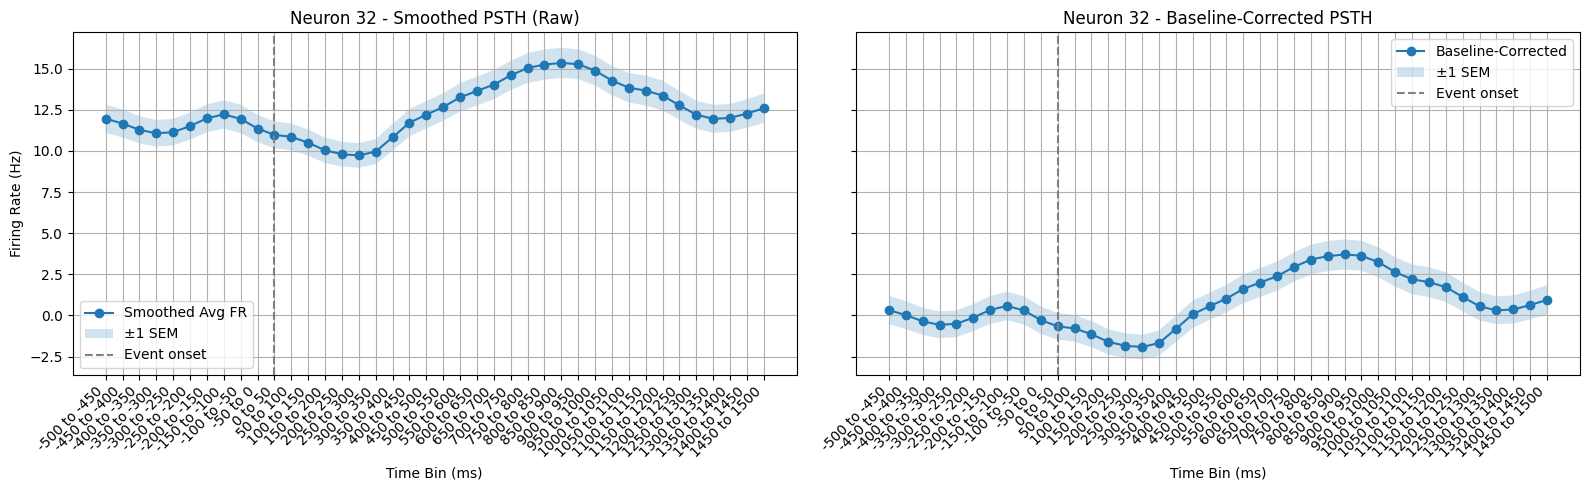

In [6]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Load data
df = pd.read_csv("spikes_full.csv")
df = df[df["Subject ID"] == 1].copy()
df["Trial-Aligned Spikes (ms)"] = df["Trial-Aligned Spikes (ms)"].apply(ast.literal_eval)

# Define bins
bin_edges = np.arange(-500, 1550, 50)
bin_labels = [f"{int(start)} to {int(end)}" for start, end in zip(bin_edges[:-1], bin_edges[1:])]
bin_duration = 0.05

# Prepare structure to collect binned FRs per neuron
neuron_bins = {}

for _, row in df.iterrows():
    neuron_id = row["Neuron ID"]
    spikes = np.array(row["Trial-Aligned Spikes (ms)"])
    binned_counts, _ = np.histogram(spikes, bins=bin_edges)
    fr = binned_counts / bin_duration  # convert to Hz

    if neuron_id not in neuron_bins:
        neuron_bins[neuron_id] = []

    neuron_bins[neuron_id].append(fr)

# Extract one neuron's data
neuron_id = 32
neuron_trials = np.array(neuron_bins[neuron_id])  # shape: (n_trials, n_bins)

# Compute average and SEM
avg_fr = np.mean(neuron_trials, axis=0)
sem_fr = np.std(neuron_trials, axis=0, ddof=1) / np.sqrt(neuron_trials.shape[0])

# Apply Gaussian smoothing
smoothed_avg = gaussian_filter1d(avg_fr, sigma=1)
smoothed_sem = gaussian_filter1d(sem_fr, sigma=1)

# Baseline correction
baseline_indices = [i for i, label in enumerate(bin_labels)
                    if int(label.split(" to ")[0]) >= -500 and int(label.split(" to ")[1]) <= 0]
baseline_mean = np.mean(neuron_trials[:, baseline_indices])
baseline_corrected = smoothed_avg - baseline_mean

# Plot both
x_vals = np.arange(len(bin_labels))

fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

# Raw PSTH
axes[0].plot(x_vals, smoothed_avg, marker='o', label="Smoothed Avg FR")
axes[0].fill_between(x_vals,
                     smoothed_avg - smoothed_sem,
                     smoothed_avg + smoothed_sem,
                     alpha=0.2, label="±1 SEM")
axes[0].axvline(x=bin_labels.index("0 to 50"), color='gray', linestyle='--', label='Event onset')
axes[0].set_xticks(x_vals)
axes[0].set_xticklabels(bin_labels, rotation=45, ha='right')
axes[0].set_title(f"Neuron {neuron_id} - Smoothed PSTH (Raw)")
axes[0].set_xlabel("Time Bin (ms)")
axes[0].set_ylabel("Firing Rate (Hz)")
axes[0].grid(True)
axes[0].legend()

# Baseline-corrected PSTH
axes[1].plot(x_vals, baseline_corrected, marker='o', label="Baseline-Corrected")
axes[1].fill_between(x_vals,
                     baseline_corrected - smoothed_sem,
                     baseline_corrected + smoothed_sem,
                     alpha=0.2, label="±1 SEM")
axes[1].axvline(x=bin_labels.index("0 to 50"), color='gray', linestyle='--', label='Event onset')
axes[1].set_xticks(x_vals)
axes[1].set_xticklabels(bin_labels, rotation=45, ha='right')
axes[1].set_title(f"Neuron {neuron_id} - Baseline-Corrected PSTH")
axes[1].set_xlabel("Time Bin (ms)")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# === Load your data ===
df = pd.read_csv("spikes_full.csv")
df["Trial-Aligned Spikes (ms)"] = df["Trial-Aligned Spikes (ms)"].apply(ast.literal_eval)

# === Define bin edges and labels ===
bin_edges = np.arange(-500, 1550, 50)
bin_labels = [f"{int(start)} to {int(end)}" for start, end in zip(bin_edges[:-1], bin_edges[1:])]
bin_duration_sec = 0.05

# === Group trials by Neuron ID ===
for neuron_id, neuron_df in df.groupby("Neuron ID"):
    all_trials = []

    for spikes in neuron_df["Trial-Aligned Spikes (ms)"]:
        spikes_array = np.array(spikes)
        binned_counts, _ = np.histogram(spikes_array, bins=bin_edges)
        fr = binned_counts / bin_duration_sec
        all_trials.append(fr)

    all_trials = np.array(all_trials)

    # Skip neurons with no spikes at all
    if np.sum(all_trials) == 0:
        continue

    # === Average + SEM ===
    avg_fr = np.mean(all_trials, axis=0)
    sem_fr = np.std(all_trials, axis=0, ddof=1) / np.sqrt(all_trials.shape[0])

    # === Smooth ===
    smoothed_avg = gaussian_filter1d(avg_fr, sigma=1)
    smoothed_sem = gaussian_filter1d(sem_fr, sigma=1)

    # === Baseline correction (per neuron from -500 to 0 ms) ===
    baseline_indices = [i for i, label in enumerate(bin_labels)
                        if int(label.split(" to ")[0]) >= -500 and int(label.split(" to ")[1]) <= 0]
    baseline_mean = np.mean(all_trials[:, baseline_indices])
    baseline_corrected = smoothed_avg - baseline_mean

    # === Plot ===
    x_vals = np.arange(len(bin_labels))

    fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

    # Raw PSTH
    axes[0].plot(x_vals, smoothed_avg, marker='o', label="Smoothed Avg FR")
    axes[0].fill_between(x_vals,
                         smoothed_avg - smoothed_sem,
                         smoothed_avg + smoothed_sem,
                         alpha=0.2, label="±1 SEM")
    axes[0].axvline(x=bin_labels.index("0 to 50"), color='gray', linestyle='--', label='Stimulus Onset')
    axes[0].set_xticks(x_vals)
    axes[0].set_xticklabels(bin_labels, rotation=45, ha='right')
    axes[0].set_title(f"Neuron {neuron_id} - Raw PSTH")
    axes[0].set_xlabel("Time Bin (ms)")
    axes[0].set_ylabel("Firing Rate (Hz)")
    axes[0].legend()
    axes[0].grid(True)

    # Baseline-corrected PSTH
    axes[1].plot(x_vals, baseline_corrected, marker='o', label="Baseline-Corrected")
    axes[1].fill_between(x_vals,
                         baseline_corrected - smoothed_sem,
                         baseline_corrected + smoothed_sem,
                         alpha=0.2, label="±1 SEM")
    axes[1].axvline(x=bin_labels.index("0 to 50"), color='gray', linestyle='--', label='Stimulus Onset')
    axes[1].set_xticks(x_vals)
    axes[1].set_xticklabels(bin_labels, rotation=45, ha='right')
    axes[1].set_title(f"Neuron {neuron_id} - Baseline-Corrected PSTH")
    axes[1].set_xlabel("Time Bin (ms)")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

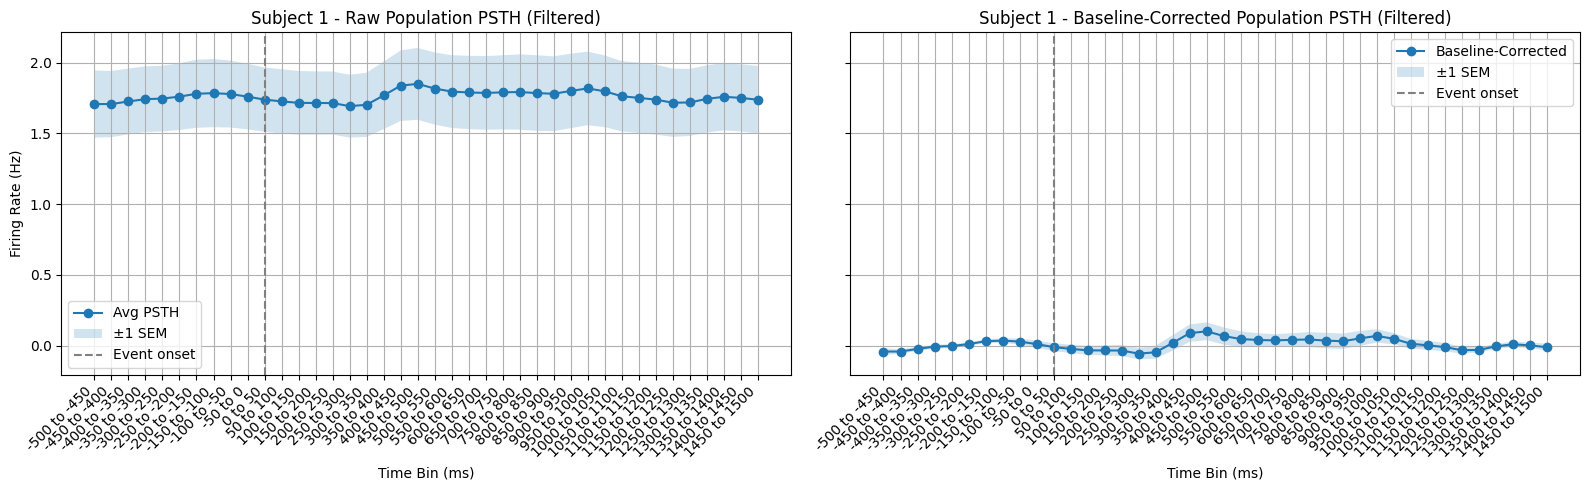

In [4]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Load data
df = pd.read_csv("spikes_full.csv")
subject_id = 1
df = df[df["Subject ID"] == subject_id].copy()
df["Trial-Aligned Spikes (ms)"] = df["Trial-Aligned Spikes (ms)"].apply(ast.literal_eval)

# Define bins
bin_edges = np.arange(-500, 1550, 50)
bin_labels = [f"{int(start)} to {int(end)}" for start, end in zip(bin_edges[:-1], bin_edges[1:])]
bin_duration = 0.05

# Collect binned FRs per neuron
neuron_bins = {}

for _, row in df.iterrows():
    neuron_id = row["Neuron ID"]
    spikes = np.array(row["Trial-Aligned Spikes (ms)"])
    binned_counts, _ = np.histogram(spikes, bins=bin_edges)
    fr = binned_counts / bin_duration  # Hz

    if neuron_id not in neuron_bins:
        neuron_bins[neuron_id] = []
    neuron_bins[neuron_id].append(fr)

# Filter out low-FR neurons (<0.15 Hz mean across full PSTH)
neuron_psth = []
for neuron_id, trials in neuron_bins.items():
    trials_array = np.array(trials)
    avg_fr = np.mean(trials_array, axis=0)
    overall_mean_fr = np.mean(avg_fr)
    if overall_mean_fr >= 0.15:
        smoothed_avg = gaussian_filter1d(avg_fr, sigma=1)
        neuron_psth.append(smoothed_avg)

# Convert to array (n_neurons, n_bins)
neuron_psth = np.array(neuron_psth)

# Compute population average and SEM
pop_avg = np.mean(neuron_psth, axis=0)
pop_sem = np.std(neuron_psth, axis=0, ddof=1) / np.sqrt(neuron_psth.shape[0])

# Baseline correction
baseline_indices = [i for i, label in enumerate(bin_labels)
                    if int(label.split(" to ")[0]) >= -500 and int(label.split(" to ")[1]) <= 0]
baseline_means = np.mean(neuron_psth[:, baseline_indices], axis=1)
baseline_corrected = neuron_psth - baseline_means[:, np.newaxis]

# Compute baseline-corrected population stats
pop_corrected_avg = np.mean(baseline_corrected, axis=0)
pop_corrected_sem = np.std(baseline_corrected, axis=0, ddof=1) / np.sqrt(baseline_corrected.shape[0])

# Plot both versions
x_vals = np.arange(len(bin_labels))

fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

# Raw PSTH
axes[0].plot(x_vals, pop_avg, label="Avg PSTH", marker='o')
axes[0].fill_between(x_vals,
                     pop_avg - pop_sem,
                     pop_avg + pop_sem,
                     alpha=0.2, label="±1 SEM")
axes[0].axvline(x=bin_labels.index("0 to 50"), color='gray', linestyle='--', label='Event onset')
axes[0].set_xticks(x_vals)
axes[0].set_xticklabels(bin_labels, rotation=45, ha='right')
axes[0].set_title(f"Subject {subject_id} - Raw Population PSTH (Filtered)")
axes[0].set_xlabel("Time Bin (ms)")
axes[0].set_ylabel("Firing Rate (Hz)")
axes[0].grid(True)
axes[0].legend()

# Baseline-corrected PSTH
axes[1].plot(x_vals, pop_corrected_avg, label="Baseline-Corrected", marker='o')
axes[1].fill_between(x_vals,
                     pop_corrected_avg - pop_corrected_sem,
                     pop_corrected_avg + pop_corrected_sem,
                     alpha=0.2, label="±1 SEM")
axes[1].axvline(x=bin_labels.index("0 to 50"), color='gray', linestyle='--', label='Event onset')
axes[1].set_xticks(x_vals)
axes[1].set_xticklabels(bin_labels, rotation=45, ha='right')
axes[1].set_title(f"Subject {subject_id} - Baseline-Corrected Population PSTH (Filtered)")
axes[1].set_xlabel("Time Bin (ms)")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()
